In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Softmax
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
from nltk.stem.snowball import PorterStemmer

## Data preprocessing
---

We will use the Cornell Movie Review Dataset as offered by the `nltk` package: 

In [2]:
nltk.download('movie_reviews', quiet=True)

True

Each review corresponds to a `file_id` which we are going to utilize to create two lists of strings; one for reviews and one for the sentiment label:

In [3]:
x = [' '.join(movie_reviews.words(file_id)) for file_id in movie_reviews.fileids()]
y = [movie_reviews.categories(file_id)[0] for file_id in movie_reviews.fileids()]

We split our data to 70% training, 15% development, and 15% testing sets:

In [4]:
y = [0 if label == 'neg' else 1 for label in y]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_test, x_dev, y_test, y_dev = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

Noting features in the raw training dataset:

In [5]:
baseline_vectorizer = TfidfVectorizer()

x_train_tfidf_raw = baseline_vectorizer.fit_transform(x_train)
x_train_tfidf_raw.shape

(1400, 34451)

It was deduced from the learning pre-established learning curves of the classsifiers that 1200 entries are sufficient for the dataset to work optimally; a learning curve plot that was implemented at the previous assignment, was clearly indicating that the assimilation of the curves occurs at 1200 training input feed, hence the new split for a development dataset was meant at 70/15/15. This split, precludes the possibility of input lack because it is comprised of 1400 entries while it allows for a fair tuning for the hyperparameters for testing and training. The development portion comes from the testing dataset

---

## Feature selection and extraction
---

We will apply stopword filtering, as well as stemming to the remaining tokens aiming to decrease the dimensionality of our problem. In addition, we will include words with document frequency larger than 25% and ignore words with less than 100 occurencies:

In [6]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

stemmer = PorterStemmer()

def stopword_and_stem_tokenizer(corpus):
    """
    Custom tokenizer function to be passed in TfidfVectorizer.
    Ignores english stopwords and applies stemming to remaining tokens.
    """
    tokens = [word for sentence in nltk.word_tokenize(corpus) for word in nltk.word_tokenize(sentence)]
    valid_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token): # ignore non-alphabetic characters
            valid_tokens.append(token)
    result = [stemmer.stem(t) for t in valid_tokens if t not in stopwords.words('english')]
    return result

Using the `TfidfVectorizer` for the remaining entries this time we get:

In [7]:
optimized_vectorizer = TfidfVectorizer(max_df=0.25, min_df=100, tokenizer=stopword_and_stem_tokenizer)
x_train_tfidf = optimized_vectorizer.fit_transform(x_train)
x_test_tfidf = optimized_vectorizer.transform(x_test)
x_dev_tfidf = optimized_vectorizer.transform(x_dev)
x_train_tfidf.shape

(1400, 599)

We notice how the number of features after the feature selection and extraction is decreased to roughly 600 feautures this time.

## Baseline Classifiers
---

We will expand the second exercise of the course by exploring the MLP classifier. For reference, we will use a Dummy, as well as the best classifier from the previous assignment as baseline models.

In [8]:
def calculate_class_AUC_score(y_true, y_pred, labels):
    """
    Calculates AUC scores for the given class label.
    """
    precision = [0, _, 1]
    recall = [1, _, 0]
    cr = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    precision[1] = cr[labels]['precision']
    recall[1] = cr[labels]['recall']
    auc_score = auc(recall, precision)
    return auc_score

### A. Dummy Classifier

In [9]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(x_train_tfidf, y_train)

# train: precision, recall, f1
predictions_train = dummy_clf.predict(x_train_tfidf)
print('Training set')
print('============')
print(classification_report(y_train, predictions_train, zero_division=0))

# train: auc
auc_class0_train = calculate_class_AUC_score(y_train, predictions_train, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_train))
auc_class1_train = calculate_class_AUC_score(y_train, predictions_train, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_train))
print('macro-average AUC: {0:.3f}'.format((auc_class0_train + auc_class1_train)/2))

Training set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       698
           1       0.50      1.00      0.67       702

    accuracy                           0.50      1400
   macro avg       0.25      0.50      0.33      1400
weighted avg       0.25      0.50      0.33      1400

class 0 AUC: -0.000
class 1 AUC: 0.751

macro-average AUC: 0.375


Testing set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.49      1.00      0.66       147

    accuracy                           0.49       300
   macro avg       0.24      0.50      0.33       300
weighted avg       0.24      0.49      0.32       300

class 0 AUC: -0.000
class 1 AUC: 0.745

macro-average AUC: 0.372


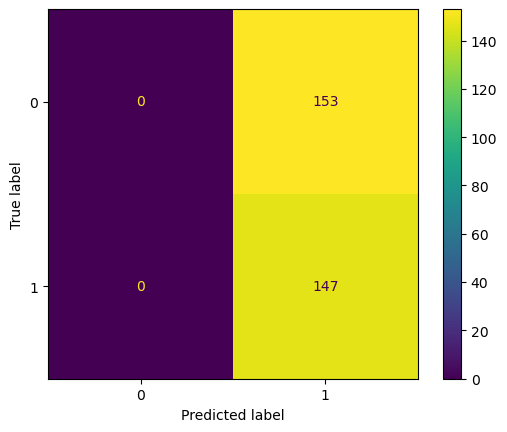

In [10]:
# test: precision, recall, f1
predictions_test = dummy_clf.predict(x_test_tfidf)
print('Testing set')
print('===========')
print(classification_report(y_test, predictions_test, zero_division=0))

# test: auc
auc_class0_test = calculate_class_AUC_score(y_test, predictions_test, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_test, predictions_test, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

# test: confusion matrix
ConfusionMatrixDisplay.from_estimator(dummy_clf, x_test_tfidf, y_test, values_format='.0f')
plt.show()

### B. Logistic Regression

The logistic regression was deemed as the best classifier from the previous assignment. The parameters used correspond to the optimal set calculated by the respective grid search implement in the previous notebook:

In [11]:
logistic_clf = LogisticRegression(solver="liblinear", penalty='l2', C=1.0)
logistic_clf.fit(x_train_tfidf, y_train)

# train: precision, recall, f1
predictions_train = logistic_clf.predict(x_train_tfidf)
print('Training set')
print('============')
print(classification_report(y_train, predictions_train))

# train: auc
auc_class0_train = calculate_class_AUC_score(y_train, predictions_train, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_train))
auc_class1_train = calculate_class_AUC_score(y_train, predictions_train, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_train))
print('macro-average AUC: {0:.3f}'.format((auc_class0_train + auc_class1_train)/2))

Training set
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       698
           1       0.89      0.90      0.90       702

    accuracy                           0.90      1400
   macro avg       0.90      0.90      0.90      1400
weighted avg       0.90      0.90      0.90      1400

class 0 AUC: 0.896
class 1 AUC: 0.898

macro-average AUC: 0.897


In [25]:
# dev: precision, recall, f1
predictions_dev = logistic_clf.predict(x_dev_tfidf)
print('Dev set')
print('===========')
print(classification_report(y_dev, predictions_dev))

# dev: auc
auc_class0_test = calculate_class_AUC_score(y_dev, predictions_dev, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_dev, predictions_dev, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

Dev set
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       149
           1       0.77      0.77      0.77       151

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300

class 0 AUC: 0.768
class 1 AUC: 0.772

macro-average AUC: 0.770


Testing set
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       153
           1       0.78      0.78      0.78       147

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300

class 0 AUC: 0.787
class 1 AUC: 0.780

macro-average AUC: 0.783


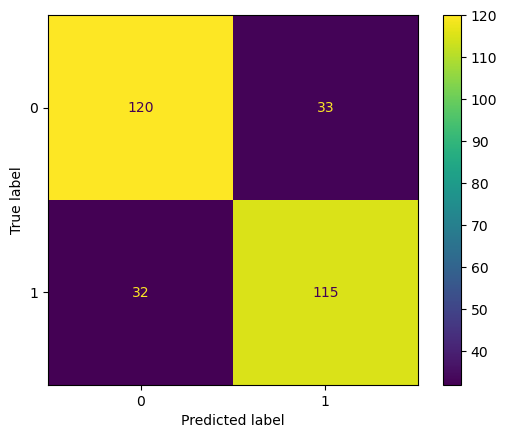

In [13]:
# test: precision, recall, f1
predictions_test = logistic_clf.predict(x_test_tfidf)
print('Testing set')
print('===========')
print(classification_report(y_test, predictions_test))

# test: auc
auc_class0_test = calculate_class_AUC_score(y_test, predictions_test, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_test, predictions_test, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

# test: confusion matrix
ConfusionMatrixDisplay.from_estimator(logistic_clf, x_test_tfidf, y_test, values_format='.0f')
plt.show()

## MLP Classifier
---

We will first transform our inputs to the necessary types:

In [14]:
x_train_r = x_train_tfidf.toarray()
y_train_r = tf.keras.utils.to_categorical(y_train, num_classes=2)

x_test_r = x_test_tfidf.toarray()
y_test_r = tf.keras.utils.to_categorical(y_test, num_classes=2)

x_dev_r = x_dev_tfidf.toarray()
y_dev_r = tf.keras.utils.to_categorical(y_dev, num_classes=2)

After manually testing different multi-layer architectures on the development set we conclude to the following model. We note the addition of Dropout layers for reguralization purposes:

In [15]:
MLP = tf.keras.models.Sequential()

MLP.add(Dense(1024, input_dim=x_train_r.shape[1], activation='relu'))
MLP.add(tf.keras.layers.Dropout(0.20))

MLP.add(Dense(512, activation='relu'))
MLP.add(tf.keras.layers.Dropout(0.25))

MLP.add(Dense(256, activation='relu'))
MLP.add(tf.keras.layers.Dropout(0.30))

MLP.add(Dense(128, activation='relu'))
MLP.add(tf.keras.layers.Dropout(0.35))

MLP.add(Dense(32, activation='relu'))
MLP.add(tf.keras.layers.Dropout(0.50))

MLP.add(Dense(2, activation='softmax'))

MLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              614400    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

Our model consists of roughly 1 million trainable parameters.

For monitoring the development performance we will use the given custom metrics function:

In [16]:
class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)      
        
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        _val_recall = recall_score(val_targ, val_predict, average='weighted')
        _val_precision = precision_score(val_targ, val_predict, average='weighted')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(' — val_f1: %f — val_precision: %f — val_recall: %f' % (_val_f1, _val_precision, _val_recall))
        return

We will set two callbacks in our training plan:

- the first one sets an early stopping rule, terminating the training process when no improvement in the validation loss occurs on 25 consecutive epochs 
- the second one calcutes validation precision, recall and F1 scores

Since we utilize the early stopping approach, we will set the training epochs to 500. Last but not least, the learning rate of the model was selected per manual tests on the development set:

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

MLP.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

history = MLP.fit(
    x_train_r, 
    y_train_r, 
    validation_data=(x_dev_r, y_dev_r),
    batch_size=128,
    epochs=500,
    shuffle=True,
    callbacks=[
        Metrics(valid_data=(x_dev_r, y_dev_r)),
        early_stopping
    ]
)

Epoch 1/500
10/10 [==============================] - 0s 4ms/steposs: 0.6928 - accuracy: 0.50
 — val_f1: 0.362105 — val_precision: 0.498275 — val_recall: 0.496667
11/11 [==============================] - 1s 55ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.4967 - val_f1: 0.3621 - val_recall: 0.4967 - val_precision: 0.4983
Epoch 2/500
10/10 [==============================] - 0s 3ms/steposs: 0.6929 - accuracy: 0.51
 — val_f1: 0.368763 — val_precision: 0.518494 — val_recall: 0.500000
11/11 [==============================] - 0s 26ms/step - loss: 0.6927 - accuracy: 0.5207 - val_loss: 0.6930 - val_accuracy: 0.5000 - val_f1: 0.3688 - val_recall: 0.5000 - val_precision: 0.5185
Epoch 3/500
10/10 [==============================] - 0s 4ms/steposs: 0.6937 - accuracy: 0.48
 — val_f1: 0.375352 — val_precision: 0.535952 — val_recall: 0.503333
11/11 [==============================] - 0s 25ms/step - loss: 0.6936 - accuracy: 0.4921 - val_loss: 0.6930 - val_accuracy: 0.5033 

10/10 [==============================] - 0s 3ms/steposs: 0.6925 - accuracy: 0.52
 — val_f1: 0.477917 — val_precision: 0.604538 — val_recall: 0.546667
11/11 [==============================] - 0s 27ms/step - loss: 0.6925 - accuracy: 0.5214 - val_loss: 0.6923 - val_accuracy: 0.5467 - val_f1: 0.4779 - val_recall: 0.5467 - val_precision: 0.6045
Epoch 25/500
10/10 [==============================] - 0s 4ms/steposs: 0.6921 - accuracy: 0.52
 — val_f1: 0.474971 — val_precision: 0.609164 — val_recall: 0.546667
11/11 [==============================] - 0s 26ms/step - loss: 0.6921 - accuracy: 0.5207 - val_loss: 0.6923 - val_accuracy: 0.5467 - val_f1: 0.4750 - val_recall: 0.5467 - val_precision: 0.6092
Epoch 26/500
10/10 [==============================] - 0s 4ms/steposs: 0.6926 - accuracy: 0.51
 — val_f1: 0.468815 — val_precision: 0.620040 — val_recall: 0.546667
11/11 [==============================] - 0s 26ms/step - loss: 0.6925 - accuracy: 0.5164 - val_loss: 0.6922 - val_accuracy: 0.5467 - val_f1: 

10/10 [==============================] - 0s 4ms/steposs: 0.6905 - accuracy: 0.55
 — val_f1: 0.482071 — val_precision: 0.640884 — val_recall: 0.556667
11/11 [==============================] - 0s 26ms/step - loss: 0.6900 - accuracy: 0.5657 - val_loss: 0.6904 - val_accuracy: 0.5567 - val_f1: 0.4821 - val_recall: 0.5567 - val_precision: 0.6409
Epoch 48/500
10/10 [==============================] - 0s 4ms/steposs: 0.6893 - accuracy: 0.57
 — val_f1: 0.482071 — val_precision: 0.640884 — val_recall: 0.556667
11/11 [==============================] - 0s 24ms/step - loss: 0.6894 - accuracy: 0.5729 - val_loss: 0.6903 - val_accuracy: 0.5567 - val_f1: 0.4821 - val_recall: 0.5567 - val_precision: 0.6409
Epoch 49/500
10/10 [==============================] - 0s 3ms/steposs: 0.6896 - accuracy: 0.56
 — val_f1: 0.498134 — val_precision: 0.653591 — val_recall: 0.566667
11/11 [==============================] - 0s 24ms/step - loss: 0.6895 - accuracy: 0.5636 - val_loss: 0.6901 - val_accuracy: 0.5667 - val_f1: 

10/10 [==============================] - 0s 4ms/steposs: 0.6793 - accuracy: 0.64
 — val_f1: 0.593254 — val_precision: 0.665846 — val_recall: 0.620000
11/11 [==============================] - 0s 25ms/step - loss: 0.6794 - accuracy: 0.6357 - val_loss: 0.6820 - val_accuracy: 0.6200 - val_f1: 0.5933 - val_recall: 0.6200 - val_precision: 0.6658
Epoch 71/500
10/10 [==============================] - 0s 3ms/steposs: 0.6784 - accuracy: 0.64
 — val_f1: 0.607103 — val_precision: 0.660596 — val_recall: 0.626667
11/11 [==============================] - 0s 25ms/step - loss: 0.6781 - accuracy: 0.6514 - val_loss: 0.6813 - val_accuracy: 0.6267 - val_f1: 0.6071 - val_recall: 0.6267 - val_precision: 0.6606
Epoch 72/500
10/10 [==============================] - 0s 4ms/steposs: 0.6764 - accuracy: 0.66
 — val_f1: 0.605852 — val_precision: 0.663129 — val_recall: 0.626667
11/11 [==============================] - 0s 26ms/step - loss: 0.6763 - accuracy: 0.6607 - val_loss: 0.6805 - val_accuracy: 0.6267 - val_f1: 

10/10 [==============================] - 0s 4ms/steposs: 0.6380 - accuracy: 0.75
 — val_f1: 0.762481 — val_precision: 0.767823 — val_recall: 0.763333
11/11 [==============================] - 0s 25ms/step - loss: 0.6378 - accuracy: 0.7521 - val_loss: 0.6444 - val_accuracy: 0.7633 - val_f1: 0.7625 - val_recall: 0.7633 - val_precision: 0.7678
Epoch 94/500
10/10 [==============================] - 0s 3ms/steposs: 0.6321 - accuracy: 0.74
 — val_f1: 0.749725 — val_precision: 0.751473 — val_recall: 0.750000
11/11 [==============================] - 0s 25ms/step - loss: 0.6314 - accuracy: 0.7507 - val_loss: 0.6411 - val_accuracy: 0.7500 - val_f1: 0.7497 - val_recall: 0.7500 - val_precision: 0.7515
Epoch 95/500
10/10 [==============================] - 0s 3ms/steposs: 0.6281 - accuracy: 0.76
 — val_f1: 0.749725 — val_precision: 0.751473 — val_recall: 0.750000
11/11 [==============================] - 0s 25ms/step - loss: 0.6269 - accuracy: 0.7679 - val_loss: 0.6378 - val_accuracy: 0.7500 - val_f1: 

10/10 [==============================] - 0s 4ms/steposs: 0.4986 - accuracy: 0.84
 — val_f1: 0.770003 — val_precision: 0.770022 — val_recall: 0.770000
11/11 [==============================] - 0s 26ms/step - loss: 0.4955 - accuracy: 0.8479 - val_loss: 0.5405 - val_accuracy: 0.7700 - val_f1: 0.7700 - val_recall: 0.7700 - val_precision: 0.7700
Epoch 117/500
10/10 [==============================] - 0s 3ms/steposs: 0.4889 - accuracy: 0.84
 — val_f1: 0.769992 — val_precision: 0.770002 — val_recall: 0.770000
11/11 [==============================] - 0s 25ms/step - loss: 0.4895 - accuracy: 0.8450 - val_loss: 0.5351 - val_accuracy: 0.7700 - val_f1: 0.7700 - val_recall: 0.7700 - val_precision: 0.7700
Epoch 118/500
10/10 [==============================] - 0s 4ms/steposs: 0.4798 - accuracy: 0.85
 — val_f1: 0.769992 — val_precision: 0.770002 — val_recall: 0.770000
11/11 [==============================] - 0s 26ms/step - loss: 0.4816 - accuracy: 0.8493 - val_loss: 0.5305 - val_accuracy: 0.7700 - val_f1

10/10 [==============================] - 0s 3ms/steposs: 0.3509 - accuracy: 0.89
 — val_f1: 0.776580 — val_precision: 0.776925 — val_recall: 0.776667
11/11 [==============================] - 0s 25ms/step - loss: 0.3477 - accuracy: 0.8993 - val_loss: 0.4671 - val_accuracy: 0.7767 - val_f1: 0.7766 - val_recall: 0.7767 - val_precision: 0.7769
Epoch 140/500
10/10 [==============================] - 0s 3ms/steposs: 0.3502 - accuracy: 0.90
 — val_f1: 0.776510 — val_precision: 0.777201 — val_recall: 0.776667
11/11 [==============================] - 0s 24ms/step - loss: 0.3508 - accuracy: 0.9000 - val_loss: 0.4655 - val_accuracy: 0.7767 - val_f1: 0.7765 - val_recall: 0.7767 - val_precision: 0.7772
Epoch 141/500
10/10 [==============================] - 0s 3ms/steposs: 0.3435 - accuracy: 0.91
 — val_f1: 0.776510 — val_precision: 0.777201 — val_recall: 0.776667
11/11 [==============================] - 0s 25ms/step - loss: 0.3460 - accuracy: 0.9107 - val_loss: 0.4642 - val_accuracy: 0.7767 - val_f1

10/10 [==============================] - 0s 4ms/steposs: 0.2509 - accuracy: 0.93
 — val_f1: 0.776510 — val_precision: 0.777201 — val_recall: 0.776667
11/11 [==============================] - 0s 26ms/step - loss: 0.2499 - accuracy: 0.9343 - val_loss: 0.4658 - val_accuracy: 0.7767 - val_f1: 0.7765 - val_recall: 0.7767 - val_precision: 0.7772
Epoch 163/500
10/10 [==============================] - 0s 3ms/steposs: 0.2382 - accuracy: 0.94
 — val_f1: 0.776510 — val_precision: 0.777201 — val_recall: 0.776667
11/11 [==============================] - 0s 24ms/step - loss: 0.2363 - accuracy: 0.9457 - val_loss: 0.4666 - val_accuracy: 0.7767 - val_f1: 0.7765 - val_recall: 0.7767 - val_precision: 0.7772
Epoch 164/500
10/10 [==============================] - 0s 4ms/steposs: 0.2430 - accuracy: 0.93
 — val_f1: 0.776510 — val_precision: 0.777201 — val_recall: 0.776667
11/11 [==============================] - 0s 24ms/step - loss: 0.2464 - accuracy: 0.9336 - val_loss: 0.4678 - val_accuracy: 0.7767 - val_f1

We visualize the model's train and validation loss: 

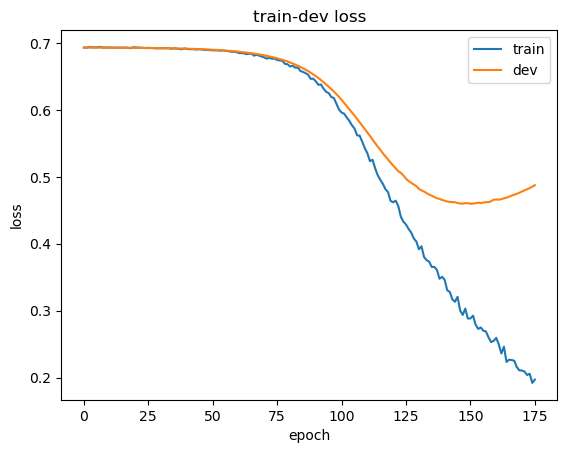

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train-dev loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

We notice how during the last epochs of training the two curves significantly deviate indicating ealy steps of overfitting.

We move on to the testing set:

In [19]:
# train: precision, recall, f1
predictions_train = np.argmax(MLP.predict(x_train_r, verbose=0), -1)
print('Training set')
print('===========')
print(classification_report(y_train, predictions_train))

# train: auc
auc_class0_test = calculate_class_AUC_score(y_train, predictions_train, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_train, predictions_train, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

Training set
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       698
           1       0.95      0.98      0.96       702

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400

class 0 AUC: 0.962
class 1 AUC: 0.963

macro-average AUC: 0.962


In [21]:
# dev: precision, recall, f1
predictions_dev = np.argmax(MLP.predict(x_dev_r, verbose=0), -1)
print('Dev set')
print('===========')
print(classification_report(y_dev, predictions_dev))

# dev: auc
auc_class0_test = calculate_class_AUC_score(y_dev, predictions_dev, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_dev, predictions_dev, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

Dev set
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       149
           1       0.76      0.80      0.78       151

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300

class 0 AUC: 0.766
class 1 AUC: 0.781

macro-average AUC: 0.774


Testing set
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       153
           1       0.78      0.79      0.78       147

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300

class 0 AUC: 0.790
class 1 AUC: 0.784

macro-average AUC: 0.787


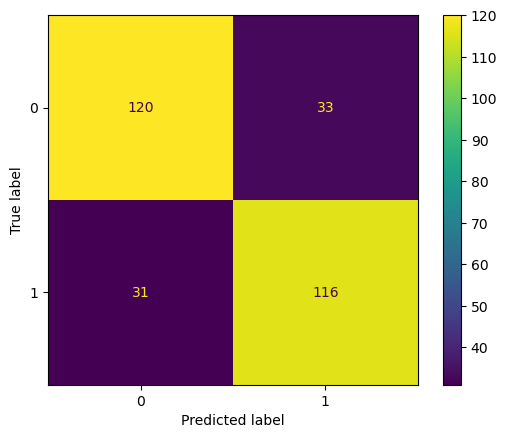

In [24]:
# test: precision, recall, f1
predictions_test = np.argmax(MLP.predict(x_test_r, verbose=0), -1)
print('Testing set')
print('===========')
print(classification_report(y_test, predictions_test))

# test: auc
auc_class0_test = calculate_class_AUC_score(y_test, predictions_test, '0')
print('class 0 AUC: {0:.3f}'.format(auc_class0_test))
auc_class1_test = calculate_class_AUC_score(y_test, predictions_test, '1')
print('class 1 AUC: {0:.3f}\n'.format(auc_class1_test))
print('macro-average AUC: {0:.3f}'.format((auc_class0_test + auc_class1_test)/2))

# test: confusion matrix
cf_matrix = confusion_matrix(y_test, predictions_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['0', '1'])
cm_display.plot()
plt.show()